In [1]:
import ROOT as rt
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree


import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi
import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
a= tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2



# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [4]:
fpath =OrderedDict()
tree = OrderedDict()


start_t = time.time()
data_year = 'full'

v1 = 'V1p17'


v2 = '/v5/v140'


data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/Data2018/'+v2+'/normalized/'




if data_year == 2016:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Run2016-HighMET-07Aug17_goodLumi.root'
elif data_year == 2017:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root'
elif data_year == 2018:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
else: #2016, 2017, 2018AB
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

decay = 'bbbb'
mass = ['15', '40','55']
ctaus  = ['100','1000','10000','100000']
# ctaus = ['10']
for ct in ctaus:
    for m in mass:
        v2 = '/v1/v140'

        mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/MC_all'+v2+'/normalized/'


        fpath['m'+m+'ctau'+ct] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+ct+'_137000pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print("NEvents",NEvents[k])
    # 22743688.0


data /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018//v5/v140/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root
NEvents 22763250.0
m15ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v140/normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-100_137000pb_weighted.root
NEvents 108761500.0
m40ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v140/normalized/ggH_HToSSTobbbb_MH-125_MS-40_ctau-100_137000pb_weighted.root
NEvents 107401250.0
m55ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v140/normalized/ggH_HToSSTobbbb_MH-125_MS-55_ctau-100_137000pb_weighted.root
NEvents 108495230.0
m15ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v140/normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_137000pb_weighted.root
NEvents 108142510.0

# load variables

In [5]:

JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

cut_based = True
cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}

nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
cluster_index = ''
nRings = {}

cscRechitClusterMuonVetoPt1 = {}
cscRechitClusterJetVetoPt1 = {}
cscRechitClusterMuonVetoPt2 = {}
cscRechitClusterJetVetoPt2 = {}
cscRechitClusterTime1 = {}
cscRechitClusterTime2 = {}
cscRechitClusterPhi1 = {}
cscRechitClusterEta1 = {}
cscRechitClusterPhi2 = {}
cscRechitClusterEta2 = {}
cscClusterSize1 = {}
cscClusterSize2 = {}
cscRechitClusterDphi1 = {}
cscRechitClusterDphi2 = {}
cscRechitClusterMuonVetoPt = {}
cscRechitClusterJetVetoPt = {}
dtRechitClusterMuonVetoPt = {}
dtRechitClusterJetVetoPt = {}
dtRechitClusterTime = {}
dtRechitClusterPhi = {}
dtRechitClusterEta = {}
dtClusterSize = {}
cscRechitClusterPhi = {}
cscRechitClusterEta = {}
cscClusterSize = {}
cscRechitClusterTime = {}
deltaEta = {}        
deltaRCluster = {}
dtRechitClusterDphi = {}
metPhi = {}
nCscClusters = {}
evtNum = {}
runNum = {}
lumiNum = {}
nDtSectors = {}
nDtStations= {}
nDtWheels= {}
nDTRechitsNoiseSec8= {}
nDTRechitsNoiseSec9= {}
nDTRechitsNoiseSec10= {}
cscRechitClusterNStation = {}
dtRechitClusterNStation ={}
dtRechitClusterMaxStation = {}
cscRechitClusterMe11Ratio = {}
nMe11 = {}
category = 0
#2csc, 2dt, 1csc+1dt
for k, T in tree.items():
    if not k == 'data' and not k[-4:] == '1000':continue
########### SELECTION: CLUSTERS ############
    sel_csccluster = np.logical_and(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_minDeltaR')<0.4, \
                                    T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))
    

    sel_csccluster = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread')<20)

    sel_dtcluster = T.array('dtRechitCluster_match_RPChits_dPhi0p5')>0
#     sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitCluster' + cluster_index + '_match_gLLP_minDeltaR')<0.4)
#     sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitCluster' + cluster_index + '_match_gLLP_dt'))
#     sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 100)
#     sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) <= 1)
#     else: sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1)

########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    sel_ev[k] = T.array('METNoMuTrigger')
 
    sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') > 200)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 2)
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 0)
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() >= 2)
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 0)
    else:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)    
########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]
   
    
   
    if category == 0:

        cscRechitClusterMuonVetoPt1[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterJetVetoPt1[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterPhi1[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterEta1[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterSize1[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterTime1[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeTotal')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterDphi1[k] =  T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterMuonVetoPt2[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
#         cscRechitClusterJetVetoPt2[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:2]
#         cscRechitClusterPhi2[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:2]
#         cscRechitClusterEta2[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:2]
#         cscClusterSize2[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:2]
#         cscRechitClusterTime2[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeTotal')[sel_csccluster][sel_ev[k]][:,:2]
#         cscRechitClusterDphi2[k] =  T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_csccluster][sel_ev[k]][:,:2]
        cscRechitClusterMe11Ratio[k] =  T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')[sel_csccluster][sel_ev[k]]  

        nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    elif category == 1:
        dtRechitClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterDphi[k] =  T.array('dtRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterMaxStation[k]=  T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]][:,:]
        evtNum[k] = T.array('evtNum')[sel_ev[k]]
        runNum[k] = T.array('runNum')[sel_ev[k]]
        lumiNum[k] = T.array('lumiSec')[sel_ev[k]]

    else:
        dtRechitClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,0]
        dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,0]
        cscRechitClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0]
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeTotal')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,0]
        nMe11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[sel_csccluster][sel_ev[k]][:,0]+\
         T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[sel_csccluster][sel_ev[k]][:,0]
        
        deltaRCluster[k] = deltaR(dtRechitClusterEta[k], dtRechitClusterPhi[k],cscRechitClusterEta[k], cscRechitClusterPhi[k])
        deltaEta[k] = dtRechitClusterEta[k]-cscRechitClusterEta[k]

        dtRechitClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]][:,0]
    weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev[k]]


    nDtSectors[k] = np.sum(np.reshape(T.array('nDTRechitsSector')>=3, (-1,4*5*12)), axis = 1)[sel_ev[k]]

    nDtStations[k] = T.array('nDtStations25')[sel_ev[k]]
    nDtWheels[k] = T.array('nDtWheels25')[sel_ev[k]]
#     nDTRechitsNoiseSec8[k]=  T.array('nDTRechitsNoiseSec8')[sel_ev[k]]
#     nDTRechitsNoiseSec9[k]=  T.array('nDTRechitsNoiseSec9')[sel_ev[k]]
#     nDTRechitsNoiseSec10[k]=  T.array('nDTRechitsNoiseSec10')[sel_ev[k]]

data 0.19866071428571427
m15ctau1000 0.1050328227571116
m40ctau1000 0.1532934131736527
m55ctau1000 0.2727272727272727
0.06876754760742188


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


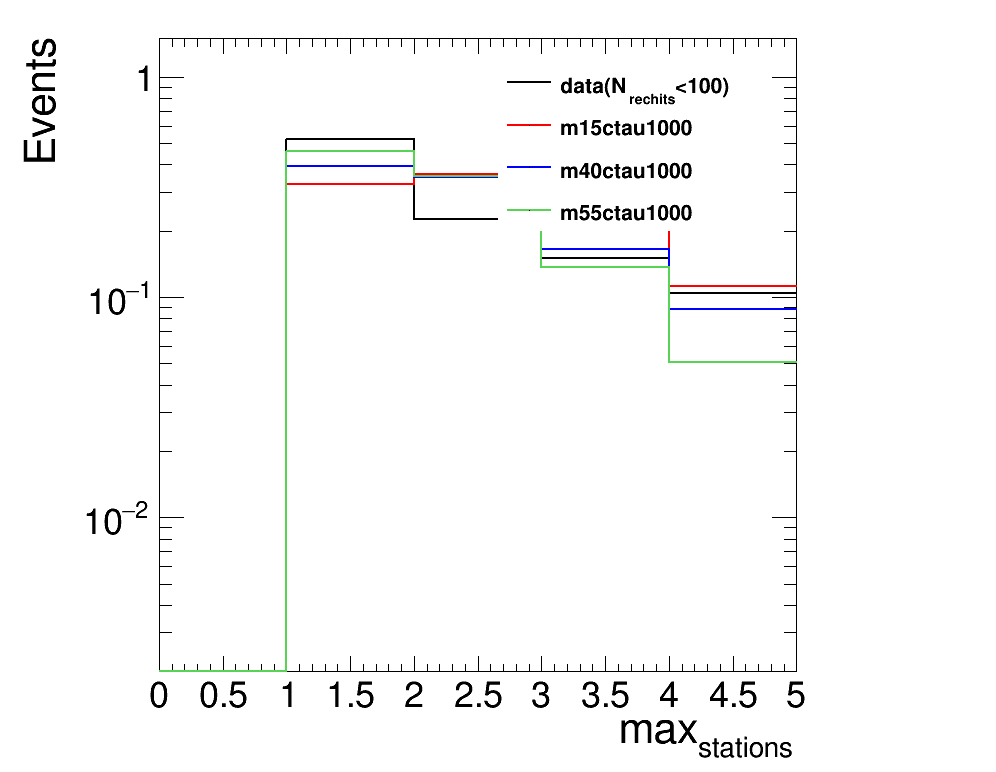

In [82]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)


leg = rt.TLegend(0.5,0.7,0.75,0.92)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

# var = [cscRechitClusterJetVetoPt1, cscRechitClusterMuonVetoPt1, cscRechitClusterMuonVetoPt1]

h = {}
for i, k in enumerate(weight.keys()):
    if not k[-4:] == '1000' and not k == 'data':continue
#     sel_dtcluster = np.logical_and(dtRechitClusterJetVetoPt[k]<80, np.abs(dtRechitClusterDphi[k])<1)
    sel_dtcluster = dtRechitClusterJetVetoPt[k]<80
    if k == 'data':sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize[k]<100)
    else: sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize[k]>=100)
    cond = sel_dtcluster.sum()==2

#     h[k] = create_TH1D((nDTRechitsNoiseSec8[k]+nDTRechitsNoiseSec9[k]+nDTRechitsNoiseSec10[k])[cond],axis_title = ['Nhits','Events'], binning=[32,0,350])
    
#     h[k] = create_TH1D((nDtWheels[k])[cond],axis_title = ['Nwheel','Events'], binning=[10,0,10])
#     h[k] = create_TH1D((nDtSectors[k])[cond],axis_title = ['nDtSectors','Events'], binning=[50,0,50])
#     h[k] = create_TH1D(np.abs(deltaEta[k]),axis_title = ['delta Eta','Events'], binning=[20,0,5])
#     h[k] = create_TH1D(nMe11[k],axis_title = ['N_{me11}','Events'], binning=[50,0,50])
    h[k] = create_TH1D(dtRechitClusterMaxStation[k][sel_dtcluster].flatten(),axis_title = ['max_{stations}','Events'], binning=[5,0,5])
#     h[k] = create_TH1D(dtRechitClusterNStation[k][sel_dtcluster],axis_title = ['N_{stations}','Events'], binning=[5,0,5])
#     h[k] = create_TH1D(cscRechitClusterNStation[k],axis_title = ['N_{stations}','Events'], binning=[5,0,5])
#     h[k] = create_TH1D(np.abs(cscRechitClusterEta[k]),axis_title = ['cluster Eta','Events'], binning=[50,1,3])
#     h[k] = create_TH1D(np.abs(dtRechitClusterEta[k][sel_dtcluster]),axis_title = ['cluster Eta','Events'], binning=[50,0,3])
#     h[k] = create_TH1D(np.abs(deltaEta[k]),axis_title = ['delta Eta','Events'], binning=[20,0,5])

#     h[k] = create_TH1D(np.abs(deltaPhi(dtRechitClusterPhi[k][sel_dtcluster][cond][:,0], dtRechitClusterPhi[k][sel_dtcluster][cond][:,1])),\
#                        axis_title = ['dphi','Events'], binning=[20,0,3.2])

#         h[k] = create_TH1D(np.abs(dtRechitClusterDphi[k])[sel_dtcluster][cond].min(),axis_title = ['dphi_{min}','Events'], binning=[32,0,3.2])



    if not k == 'data' or True:
# # #         cond = np.logical_and(cond, nDTRechitsNoiseSec8[k]+nDTRechitsNoiseSec9[k]+nDTRechitsNoiseSec10[k]>120)
# # #         cond = np.logical_and(cond, nDTRechitsNoiseSec8[k]>50)
# # #         cond = np.logical_and(cond, nDTRechitsNoiseSec9[k]>25)
# # #         cond = np.logical_and(cond, nDTRechitsNoiseSec10[k]>10)
# #         cond = np.logical_and(cond,nDtSectors[k]<20)
# #         print(k, np.count_nonzero(cond)/h[k].Integral())
#         cond = np.logical_and(dtRechitClusterNStation[k] == 4, cscRechitClusterNStation[k] == 4)
#         cond = np.abs(cscRechitClusterEta[k])<2
#         cond = nMe11[k]<10
        temp = np.logical_and(dtRechitClusterMaxStation[k][sel_dtcluster][cond][:,0]==1, dtRechitClusterMaxStation[k][sel_dtcluster][cond][:,1]==1)
        print(k, np.count_nonzero(temp)/np.count_nonzero(cond))

    if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<100)')
    else: leg.AddEntry(h[k],k)
    h[k].SetLineColor(std_color_list[i])
    if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1.5)
    h[k].SetMinimum(0.002)
    h[k].Draw('hist same')
leg.Draw()
c.SetRightMargin(0.2)


# if setlog: 
c.SetLogy()
c.Draw()
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/validation_region/"+v2+'/'+k+".png")
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/validation_region/"+v2+'/'+k+".C")
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/validation_region/"+v2+'/'+k+".pdf")




print(time.time()-start_t)

# dphi optimization

data 345.0
m15ctau1000 880.0
m40ctau1000 800.0
m55ctau1000 113.0
0.031250715255737305


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


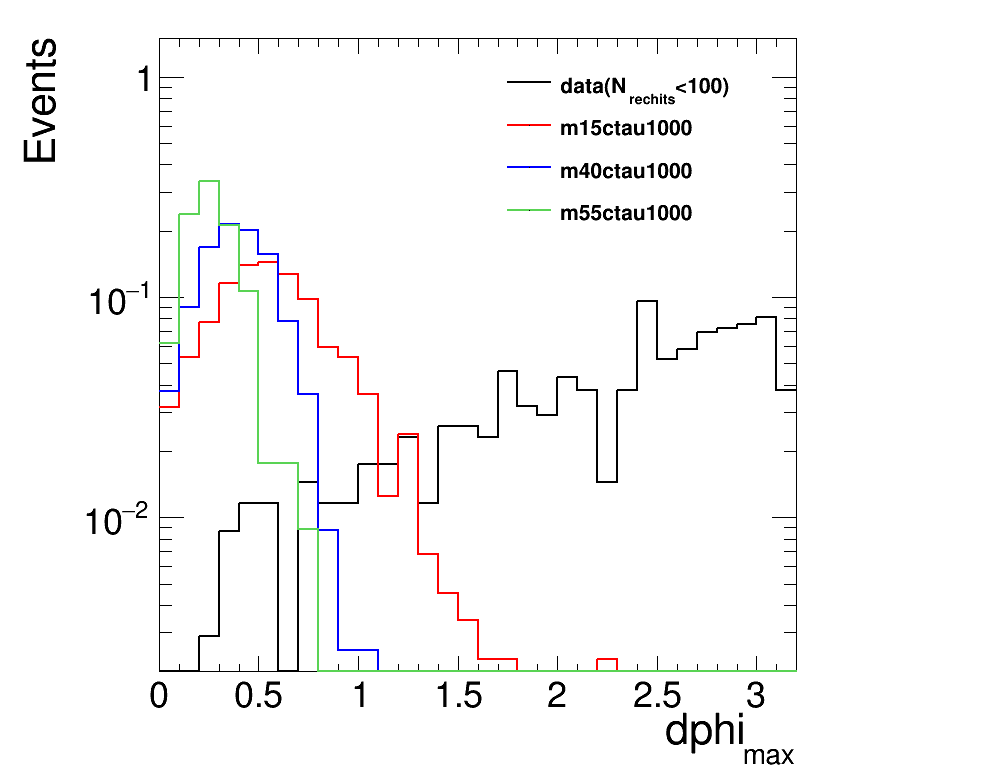

In [508]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)


leg = rt.TLegend(0.5,0.7,0.75,0.92)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

# var = [cscRechitClusterJetVetoPt1, cscRechitClusterMuonVetoPt1, cscRechitClusterMuonVetoPt1]

h = {}
for i, k in enumerate(weight.keys()):
    if not k[-4:] == '1000' and not k == 'data':continue
    if category == 0:
        sel_csccluster = cscRechitClusterJetVetoPt1[k]<50    
        if k == 'data':sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]<100)
        else: sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]>=100)
        cond = sel_csccluster.sum()==2
        signal = np.sum(weight[k][cond])
        h[k] = create_TH1D(np.abs(cscRechitClusterDphi1[k][sel_csccluster][cond]).max(),axis_title = ['dphi_{max}','Events'], binning=[32,0,3.2])
        h[k] = create_TH1D(np.abs(cscRechitClusterDphi1[k])[sel_csccluster][cond].min(),axis_title = ['dphi_{min}','Events'], binning=[32,0,3.2])

    elif category == 1:
        sel_dtcluster = dtRechitClusterJetVetoPt[k]<50    
        if k == 'data':sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize[k]<100)
        else: sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize[k]>=100)
        cond = sel_dtcluster.sum()==2
        signal = np.sum(weight[k][cond])
        h[k] = create_TH1D(np.abs(dtRechitClusterDphi[k][sel_dtcluster][cond]).max(),axis_title = ['dphi_{max}','Events'], binning=[32,0,3.2])
#         h[k] = create_TH1D(np.abs(dtRechitClusterDphi[k])[sel_dtcluster][cond].min(),axis_title = ['dphi_{min}','Events'], binning=[32,0,3.2])


    if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<100)')
    else: leg.AddEntry(h[k],k)
    print(k, h[k].Integral())
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1.5)
    h[k].SetMinimum(0.002)
    h[k].Draw('hist same')
leg.Draw()
c.SetRightMargin(0.2)


# if setlog: 
c.SetLogy()
c.Draw()
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/validation_region/"+v2+'/'+k+".png")
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/validation_region/"+v2+'/'+k+".C")
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/validation_region/"+v2+'/'+k+".pdf")




print(time.time()-start_t)

m15ctau1000 0.4
m15ctau1000max 1.0
m40ctau1000 0.33
m40ctau1000max 0.63
m55ctau1000 0.21
m55ctau1000max 0.45


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


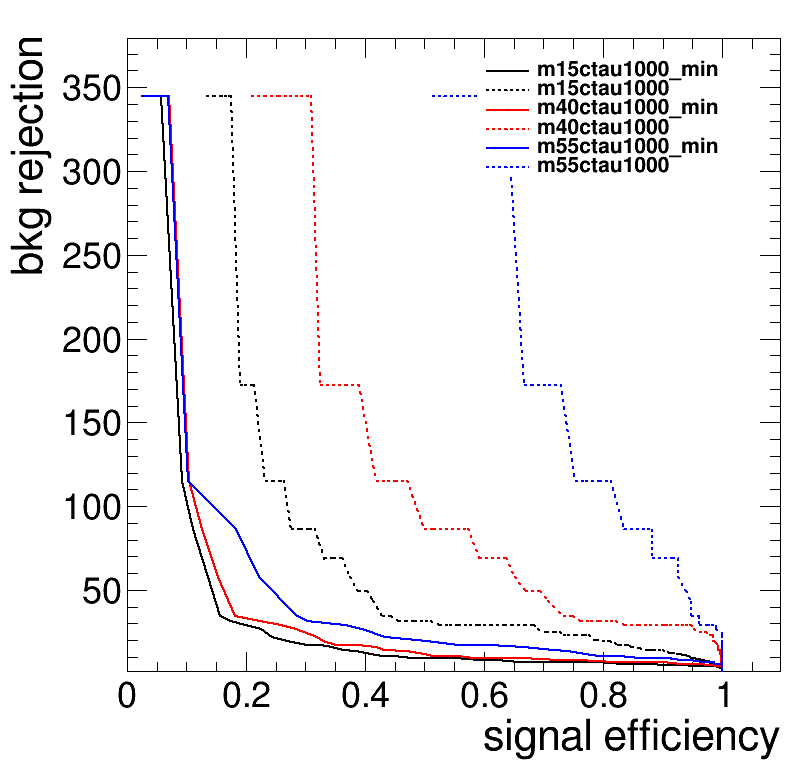

In [518]:
# ROC curve

rt.gStyle.SetPaintTextFormat("6.2f")


leg = rt.TLegend(0.6,0.77,0.90,0.92)
# leg = rt.TLegend(0.6,0.3,0.90,0.5)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
r = {}


jetveto = 50
i = 0
threshold = list(np.arange(0,1.5,0.01))
for k in weight.keys():
    signal = []
    bkg = []
    if k == 'data':continue
    for j, dphi in enumerate(threshold):
        if category == 0:
            ### signal ###
            sel_csccluster = cscRechitClusterJetVetoPt1[k]<jetveto
            sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]>=100)
            cond = sel_csccluster.sum()==2
            sig_denom = np.sum(weight[k][cond])
            cond = np.logical_and(cond, np.abs(cscRechitClusterDphi1[k][sel_csccluster]).min()<dphi)
            signal.append(np.sum(weight[k][cond])/sig_denom)

            ### bkg ###
            sel_csccluster = cscRechitClusterJetVetoPt1['data']<jetveto
            sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1['data']<100)
            cond = sel_csccluster.sum()==2
            bkg_denom = np.count_nonzero(cond)
            cond = np.logical_and(cond, np.abs(cscRechitClusterDphi1['data'][sel_csccluster]).min()<dphi)
            bkg.append(np.count_nonzero(cond)/bkg_denom)
        elif category == 1:
            ### signal ###
            sel_dtcluster = dtRechitClusterJetVetoPt[k]<jetveto
            sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize[k]>=100)
            cond = sel_dtcluster.sum()==2
            sig_denom = np.sum(weight[k][cond])
            cond = np.logical_and(cond, np.abs(dtRechitClusterDphi[k][sel_dtcluster]).min()<dphi)
            signal.append(np.sum(weight[k][cond])/sig_denom)

            ### bkg ###
            sel_dtcluster = dtRechitClusterJetVetoPt['data']<jetveto
            sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize['data']<100)
            cond = sel_dtcluster.sum()==2
            bkg_denom = np.count_nonzero(cond)
            cond = np.logical_and(cond, np.abs(dtRechitClusterDphi['data'][sel_dtcluster]).min()<dphi)
            bkg.append(np.count_nonzero(cond)/bkg_denom)
    h[k] = create_TGraph(np.array(signal)[np.array(bkg)>0], 1./np.array(bkg)[np.array(bkg)>0], axis_title= ['signal efficiency', 'bkg rejection'])
#     h[k] = create_TGraph(threshold, np.array(signal), axis_title= ['threshold','signal efficiency'])
    print(k, np.array(threshold)[np.argmin(np.abs(np.array(signal)-0.9))])
    signal = []
    bkg = []
    for j, dphi in enumerate(threshold):
        if category == 0:
            ### signal ###
            sel_csccluster = cscRechitClusterJetVetoPt1[k]<jetveto
            sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]>=100)
            cond = sel_csccluster.sum()==2
            sig_denom = np.sum(weight[k][cond])
            cond = np.logical_and(cond, np.abs(cscRechitClusterDphi1[k][sel_csccluster]).max()<dphi)
            signal.append(np.sum(weight[k][cond])/sig_denom)

            ### bkg ###
            sel_csccluster = cscRechitClusterJetVetoPt1['data']<jetveto
            sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1['data']<100)
            cond = sel_csccluster.sum()==2
            bkg_denom = np.count_nonzero(cond)
            cond = np.logical_and(cond, np.abs(cscRechitClusterDphi1['data'][sel_csccluster]).max()<dphi)
            bkg.append(np.count_nonzero(cond)/bkg_denom)
        elif category == 1:
            ### signal ###
            sel_dtcluster = dtRechitClusterJetVetoPt[k]<jetveto
            sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize[k]>=100)
            cond = sel_dtcluster.sum()==2
            sig_denom = np.sum(weight[k][cond])
            cond = np.logical_and(cond, np.abs(dtRechitClusterDphi[k][sel_dtcluster]).max()<dphi)
            signal.append(np.sum(weight[k][cond])/sig_denom)

            ### bkg ###
            sel_dtcluster = dtRechitClusterJetVetoPt['data']<jetveto
            sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize['data']<100)
            cond = sel_dtcluster.sum()==2
            bkg_denom = np.count_nonzero(cond)
            cond = np.logical_and(cond, np.abs(dtRechitClusterDphi['data'][sel_dtcluster]).max()<dphi)
            bkg.append(np.count_nonzero(cond)/bkg_denom)
        
    h[k+'max'] = create_TGraph(np.array(signal)[np.array(bkg)>0], 1./np.array(bkg)[np.array(bkg)>0], axis_title= ['signal efficiency', 'bkg rejection'])
#     h[k+'max'] = create_TGraph(threshold, np.array(signal), axis_title= ['threshold','signal efficiency'])
#     h[k].GetXaxis().SetRangeUser(0.8,1)
    h[k].GetYaxis().SetLimits(1,25)

    print(k+'max', np.array(threshold)[np.argmin(np.abs(np.array(signal)-0.9))])
    h[k].SetLineColor(std_color_list[i])
    h[k].SetLineWidth(2)
    h[k+'max'].SetLineColor(std_color_list[i])
    h[k+'max'].SetLineWidth(2)
    h[k+'max'].SetLineStyle(2)
    leg.AddEntry(h[k],k+'_min')
    leg.AddEntry(h[k+'max'],k)
    h[k].Draw('LA' if i == 0 else 'Lsame')
    h[k+'max'].Draw('Lsame')
    i+=1
# c.SetRightMargin(0.2)
leg.Draw()
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_'+k+'_'+str(data_year)+'_'+varName[j]+'.png')
c.Draw()
# print(time.time()-start_t)


# 2d optimization

In [ ]:
# for a set of cuts
# print background level and signal level


rt.gStyle.SetPaintTextFormat("6.2f")


leg = rt.TLegend(0.6,0.77,0.90,0.92)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
r = {}
print('Integral, efficiency, efficiencyUp, efficiencyDown, Integral*Eff^2, Integral*EffUp^2, Integral*EffDown^2')
soverb = rt.TH2D('name', 'title', 10,0,100,10,0,100)
soverb.GetXaxis().SetTitle('muon veto')
soverb.GetYaxis().SetTitle('jet veto')
for i, muonveto in enumerate(np.arange(0,100,10)):
    for j, jetveto in enumerate(np.arange(0,100,10)):
        
        
        ### signal yield for 15 GeV 1m ###
        k = 'm15ctau1000'
        sel_csccluster = np.logical_and(cscRechitClusterJetVetoPt1[k]<jetveto, cscRechitClusterMuonVetoPt1[k]<muonveto)
        sel_csccluster = np.logical_and(sel_csccluster, np.abs(cscRechitClusterDphi1[k])<1)
        sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]>=100)
        cond = sel_csccluster.sum()>=2
        signal = np.sum(weight[k][cond])
        
        ### background exponential fit ###
        k = 'data'
        sel_csccluster = np.logical_and(cscRechitClusterJetVetoPt1[k]<jetveto, cscRechitClusterMuonVetoPt1[k]<muonveto)
        sel_csccluster = np.logical_and(sel_csccluster, np.abs(cscRechitClusterDphi1[k])<1)
        sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]<100)
        cond = sel_csccluster.sum()>=2
        h = create_TH1D( cscClusterSize1[k][sel_csccluster][cond][:,:2].flatten(), axis_title=['N_{hits}', 'Events'], name=k, binning=[5,50,100])
        r = h.Fit('expo', 'LRSQ+', '', 50,100)
        a = r.Parameter(1)
        if h.Integral()==0:continue
        eff = math.exp(100*a)/(math.exp(50*a)-math.exp(100*a))
        a = r.Parameter(1) + r.Error(1)
        effUp = math.exp(100*a)/(math.exp(50*a)-math.exp(100*a))
        a = r.Parameter(1) - r.Error(1)
        effDown = math.exp(100*a)/(math.exp(50*a)-math.exp(100*a))
        assert(h.Integral()/2 == np.count_nonzero(cond))
#         print(muonveto, jetveto, h.Integral()/2, eff, effUp, effDown, h.Integral()*eff**2, h.Integral()*effUp**2, h.Integral()*effDown**2, signal, signal/(h.Integral()*eff**2)**0.5 )
        # s/sqrt(b)
        soverb.SetBinContent(i+1,j+1,signal*0.01/(h.Integral()*eff**2*0.5)**0.5)
        
        # bkg prediction
#         soverb.SetBinError(i+1,j+1,max(h.Integral()/2*effUp**2-h.Integral()*eff**2, h.Integral()/2*eff**2-h.Integral()*effDown**2))
#         soverb.SetBinContent(i+1,j+1,h.Integral()*eff**2)
#         soverb.SetBinContent(i+1,j+1,signal)
soverb.Draw('colz textE')

c.SetRightMargin(0.13)
# leg.Draw()
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_'+k+'_'+str(data_year)+'_'+varName[j]+'.png')
c.Draw()
# print(time.time()-start_t)


# optimization of Nrechits vs jet veto

Integral, efficiency, efficiencyUp, efficiencyDown, Integral*Eff^2, Integral*EffUp^2, Integral*EffDown^2


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: name (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: R

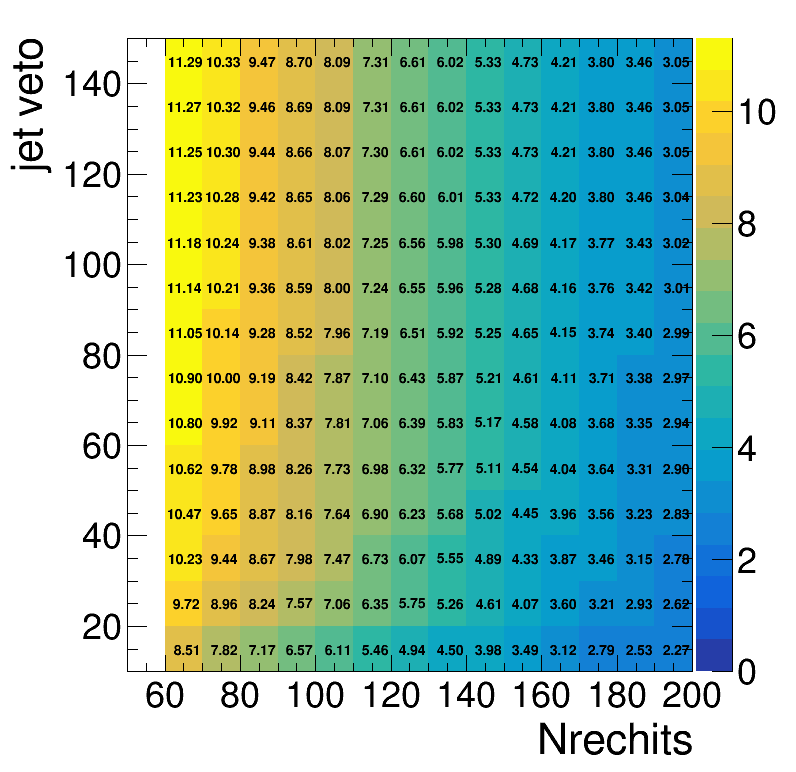

In [36]:
# for a set of cuts
# print background level and signal level




leg = rt.TLegend(0.6,0.77,0.90,0.92)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
r = {}
print('Integral, efficiency, efficiencyUp, efficiencyDown, Integral*Eff^2, Integral*EffUp^2, Integral*EffDown^2')
if category == 0:dphi = 1.2
elif category == 1: dphi = 1.0
else: dphi = 1
plot = 1 # 0 = sovers_b; 1 = signal yield; 2 = background prediction
ybins, ymin, ymax = 14,10,150
soverb = rt.TH2D('name', 'title', 15,50,200, ybins,ymin,ymax)
soverb.GetYaxis().SetTitle('jet veto')
soverb.GetXaxis().SetTitle('Nrechits')
for i, Nrechits in enumerate(np.arange(50,200,10)):
    for j, jetveto in enumerate(np.arange(ymin,ymax,int((ymax-ymin)/ybins))):
        
#         if not (jetveto==10 and Nrechits==100):continue
        
        k = 'm15ctau1000'
        if category == 0:
            ### signal yield for 15 GeV 1m ###
            sel_csccluster = np.logical_and(cscRechitClusterJetVetoPt1[k]<jetveto, np.abs(cscRechitClusterDphi1[k])<dphi)
            sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]>=Nrechits)
            cond = sel_csccluster.sum()>=2
            signal = np.sum(weight[k][cond])*(1-0.0154)**2
            ### background exponential fit ###
            k = 'data'
            sel_csccluster = np.logical_and(cscRechitClusterJetVetoPt1[k]<jetveto, np.abs(cscRechitClusterDphi1[k])<dphi)
            sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]<Nrechits)
            cond = sel_csccluster.sum()>=2
            h = create_TH1D( cscClusterSize1[k][sel_csccluster][cond][:,:2].flatten(), axis_title=['N_{hits}', 'Events'], name=k, binning=[5,50,100])
        elif category == 1:
            ### signal yield for 15 GeV 1m ###
            sel_dtcluster = np.logical_and(dtRechitClusterJetVetoPt[k]<jetveto, np.abs(dtRechitClusterDphi[k])<dphi)
            sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize[k]>=Nrechits)
            cond = sel_dtcluster.sum()>=2
            signal = np.sum(weight[k][cond])
            ### background exponential fit ###
            k = 'data'
            sel_dtcluster = np.logical_and(dtRechitClusterJetVetoPt[k]<jetveto, np.abs(dtRechitClusterDphi[k])<dphi)
            sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize[k]<Nrechits)
            cond = sel_dtcluster.sum()>=2
            h = create_TH1D( dtClusterSize[k][sel_dtcluster][cond][:,:2].flatten(), axis_title=['N_{hits}', 'Events'], name=k, binning=[5,50,100])
            
        ### exponential fit and calculate efficiency ###
        r = h.Fit('expo', 'LRSQ+', '', 50, 100)
        a = r.Parameter(1)
        if h.Integral()==0:continue
#         eff = math.exp(Nrechits*a)/(math.exp(50*a)-math.exp(100*a))
#         a = r.Parameter(1) + r.Error(1)
#         effUp = math.exp(Nrechits*a)/(math.exp(50*a)-math.exp(100*a))
#         a = r.Parameter(1) - r.Error(1)
#         effDown = math.exp(Nrechits*a)/(math.exp(50*a)-math.exp(100*a))

        eff = math.exp(Nrechits*a)/(math.exp(50*a)-math.exp(Nrechits*a))
        a = r.Parameter(1) + r.Error(1)
        effUp = math.exp(Nrechits*a)/(math.exp(50*a)-math.exp(Nrechits*a))
        a = r.Parameter(1) - r.Error(1)
        effDown = math.exp(Nrechits*a)/(math.exp(50*a)-math.exp(Nrechits*a))
        
        if plot == 0:# s/sqrt(b)
            soverb.SetBinContent(i+1,j+1,signal*0.01/(signal*0.01+h.Integral()*eff**2*0.5)**0.5)
            rt.gStyle.SetPaintTextFormat("6.1f")
        elif plot == 1:# signal prediction
            soverb.SetBinContent(i+1,j+1,signal*0.01)
            rt.gStyle.SetPaintTextFormat("6.2f")
        else:# bkg prediction
            soverb.SetBinError(i+1,j+1,max(h.Integral()/2*effUp**2-h.Integral()*eff**2, h.Integral()/2*eff**2-h.Integral()*effDown**2))
            soverb.SetBinContent(i+1,j+1,h.Integral()*0.5*eff**2)
            rt.gStyle.SetPaintTextFormat("6.2f")    
        h.Delete()
if plot <= 1:soverb.Draw('colz text ')
else:soverb.Draw('colz text E')
            
            
            

c.SetRightMargin(0.13)
# leg.Draw()
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_'+k+'_'+str(data_year)+'_'+varName[j]+'.png')
c.Draw()
# print(time.time()-start_t)


Integral, efficiency, efficiencyUp, efficiencyDown, Integral*Eff^2, Integral*EffUp^2, Integral*EffDown^2
[55 92 97 94 52 62 92] [53 81 67 56 50 58 66]
[1607909397  171280648   68479309   23321505  188857988   76348254
   47585029]
[0.       0.       0.       0.       7.590572 0.       0.      ] [  8.163836 181.92798    0.         0.         0.         0.
  18.474098]
[0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
[0 4 3 2 0 4 2]
[3 5 2 4 5 5 4]
14.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


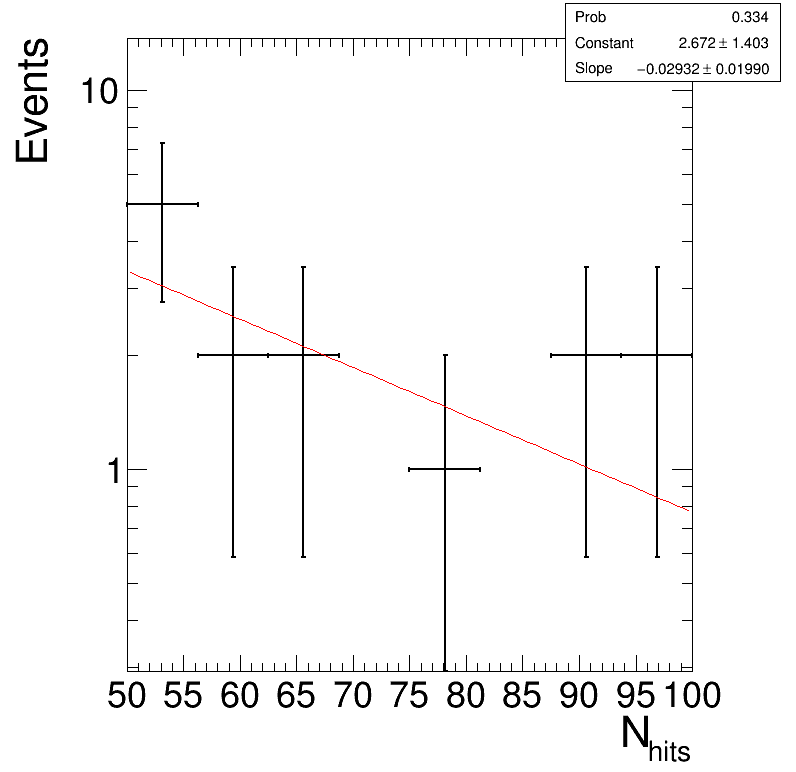

In [584]:
# plot exponential for background


# for a set of cuts
# print background level and signal level




leg = rt.TLegend(0.6,0.77,0.90,0.92)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
r = {}
print('Integral, efficiency, efficiencyUp, efficiencyDown, Integral*Eff^2, Integral*EffUp^2, Integral*EffDown^2')
if category == 0:dphi = 1.2
elif category == 1: dphi = 1.0
else: dphi = 1

Nrechits = 100
for j, jetveto in enumerate(np.arange(0,200,10)):
    if not jetveto == 10:continue
#         if not (jetveto==10 and Nrechits==100):continue

    k = 'data'
    if category == 0:
        sel_csccluster = np.logical_and(cscRechitClusterJetVetoPt1[k]<jetveto, np.abs(cscRechitClusterDphi1[k])<dphi)
        sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]<Nrechits)
        cond = sel_csccluster.sum()>=2
        h = create_TH1D( cscClusterSize1[k][sel_csccluster][cond][:,:2].flatten(), axis_title=['N_{hits}', 'Events'], name=k, binning=[5,50,100])
    elif category == 1:
        ### background exponential fit ###
        sel_dtcluster = np.logical_and(dtRechitClusterJetVetoPt[k]<jetveto, np.abs(dtRechitClusterDphi[k])<dphi)
        sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterSize[k]<Nrechits)
        cond = sel_dtcluster.sum()>=2
        print(dtClusterSize[k][sel_dtcluster][cond][:,0], dtClusterSize[k][sel_dtcluster][cond][:,1])
        print(evtNum[k][cond])
#         for j in range(len(evtNum[k][cond])):
#             print(str(runNum[k][cond][i])+":"+str(lumiNum[k][cond][i])+":"+str(evtNum[k][cond][i]))
#         print(deltaPhi(dtRechitClusterPhi[k][sel_dtcluster][cond][:,0], dtRechitClusterPhi[k][sel_dtcluster][cond][:,1]))
        print(dtRechitClusterMuonVetoPt[k][sel_dtcluster][cond][:,0], dtRechitClusterMuonVetoPt[k][sel_dtcluster][cond][:,1])
        print(dtRechitClusterJetVetoPt[k][sel_dtcluster][cond][:,0], dtRechitClusterJetVetoPt[k][sel_dtcluster][cond][:,1])
        
        print(tree[k].array('nDtRings')[sel_ev[k]][cond])
        print(tree[k].array('nDtWheels25')[sel_ev[k]][cond])
        h = create_TH1D( dtClusterSize[k][sel_dtcluster][cond][:,:2].flatten(), axis_title=['N_{hits}', 'Events'], name=k, binning=[8,50,100])

    ### exponential fit and calculate efficiency ###
    print(h.Integral())
    r = h.Fit('expo', 'LRSQ+', '', 50, 100)
    a = r.Parameter(1)
    if h.Integral()==0:continue
    eff = math.exp(Nrechits*a)/(math.exp(50*a)-math.exp(100*a))
    a = r.Parameter(1) + r.Error(1)
    effUp = math.exp(Nrechits*a)/(math.exp(50*a)-math.exp(100*a))
    a = r.Parameter(1) - r.Error(1)
    effDown = math.exp(Nrechits*a)/(math.exp(50*a)-math.exp(100*a))

    h.Draw('E1')
            
            
            
c.SetLogy()
c.SetRightMargin(0.13)
# leg.Draw()
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_'+k+'_'+str(data_year)+'_'+varName[j]+'.png')
c.Draw()
# print(time.time()-start_t)


# optimization of jet veto

m15ctau1000 260.11575
m40ctau1000 485.49884
m55ctau1000 63.468704


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


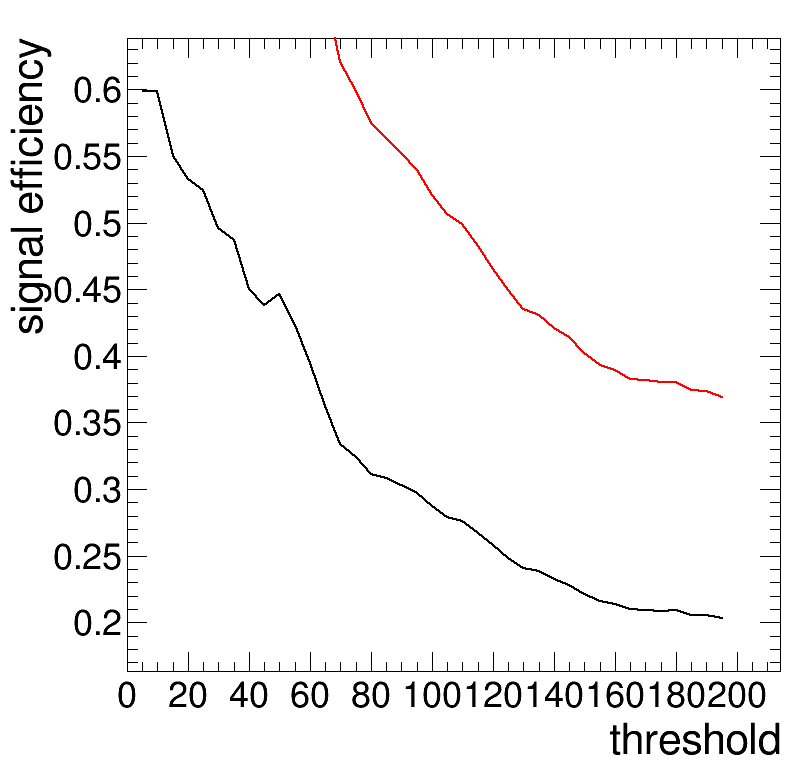

In [291]:
# for a set of cuts
# print background level and signal level


rt.gStyle.SetPaintTextFormat("6.2f")


leg = rt.TLegend(0.6,0.77,0.90,0.92)
# leg = rt.TLegend(0.6,0.3,0.90,0.5)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
r = {}

dphi = 1
muonveto = 20000
i = 0
threshold = list(np.arange(5,200,5))
for k in cscClusterSize1.keys():
    signal = []
    bkg = []
    if k == 'data':continue
    
    for j, jetveto in enumerate(threshold):
        ### signal ###
        sel_csccluster = np.logical_and(np.abs(cscRechitClusterDphi1[k])<dphi,  cscRechitClusterMuonVetoPt1[k]<muonveto)
        sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1[k]>=100)
        cond = sel_csccluster.sum()>=2
        sig_denom = np.sum(weight[k][cond])
        sel_csccluster = np.logical_and(sel_csccluster, cscRechitClusterJetVetoPt1[k]<jetveto)
        cond = sel_csccluster.sum()>=2
        signal.append(np.sum(weight[k][cond]))
    
    
        ### bkg ###
        sel_csccluster = np.logical_and( np.abs(cscRechitClusterDphi1['data'])<dphi, cscRechitClusterMuonVetoPt1['data']<muonveto)
        sel_csccluster = np.logical_and(sel_csccluster, cscClusterSize1['data']<100)
        cond = sel_csccluster.sum()>=2
        bkg_denom = np.count_nonzero(cond)
        sel_csccluster = np.logical_and(sel_csccluster,cscRechitClusterJetVetoPt1['data']<jetveto)
        cond = sel_csccluster.sum()>=2
        bkg.append(np.count_nonzero(cond))
        if jetveto == 50:print(k, signal[-1])
#     h[k] = create_TGraph(signal, bkg, axis_title= ['signal efficiency', 'bkg efficiency'])
#     h[k] = create_TGraph(threshold, bkg, axis_title= ['threshold', 'bkg efficiency'])
#     h[k] = create_TGraph(np.array(signal)[np.array(bkg)>0], 1./np.array(bkg)[np.array(bkg)>0], axis_title= ['signal efficiency', 'bkg rejection'])
#     h[k] = create_TGraph(np.array(signal)[np.array(bkg)>0], 1./np.array(bkg)[np.array(bkg)>0], axis_title= ['signal efficiency', 'bkg rejection'])
    h[k] = create_TGraph(threshold, 0.01*np.array(signal)/np.array(bkg)**0.5, axis_title= ['threshold', 'signal efficiency'])
#     h[k].GetXaxis().SetLimits(0.7,1)
#     h[k].GetYaxis().SetRangeUser(0.5,50)
    h[k].SetLineColor(std_color_list[i])
    h[k].SetLineWidth(2)
    leg.AddEntry(h[k],k)
    h[k].Draw('LA' if i == 0 else 'Lsame')
    i+=1
    
# c.SetRightMargin(0.2)
# leg.Draw()
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_'+k+'_'+str(data_year)+'_'+varName[j]+'.png')
c.Draw()
# print(time.time()-start_t)


## Distribution for event level variables in different binnings

0 1
1 22.0
2 14.0
3 5.0
4 1.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).


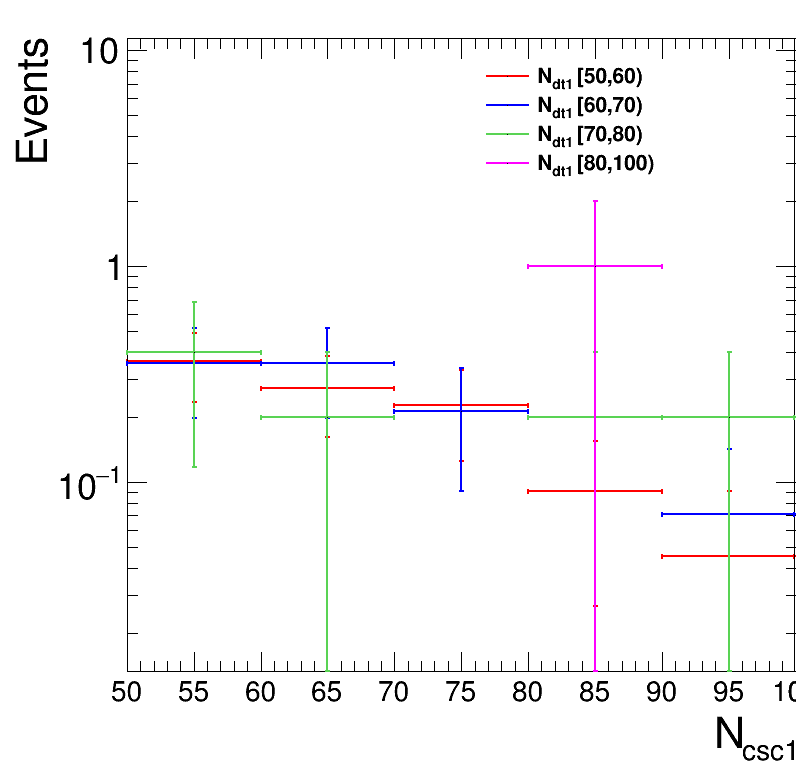

In [42]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


# Plotting ncsc
start_t = time.time()



br = 1
k = 'data'
name = '\Delta \Phi (jet,met)'
name = 'N_{dt}'
cuts = [ 50, 70, 80, 100]
# cuts = [50, 100]
if category == 0:
    var = [cscClusterSize1[k], cscClusterSize2[k]]
    varName = ['cscRechitClusterSize1', 'cscRechitClusterSize2']
    xaxis = ['N_{csc1}','N_{csc2}']
    cuts = [ 50, 60, 70, 100]


elif category == 1:
    var = [dtClusterSize1[k], dtClusterSize2[k]]
    varName = ['dtRechitClusterSize1', 'dtRechitClusterSize2']
    xaxis = ['N_{dt1}','N_{dt2}']
    cuts = [ 50, 60, 70, 100]


else:
    var = [cscClusterSize1[k], dtClusterSize1[k]]
    cuts = [ 50, 60, 70, 80, 100]

    varName = ['cscRechitClusterSize1', 'dtRechitClusterSize1']
    xaxis = ['N_{csc1}','N_{dt1}']
cut_index = 1

for j,v in enumerate(var):
    if not j ==(len(var)-1-cut_index):continue
    print(j, cut_index)
    leg = rt.TLegend(0.6,0.77,0.90,0.92)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    h = {}
    rt.gStyle.SetOptFit(1011)
    maxb = 0
    for i,cut in enumerate(cuts):

        metcut = 200
        if i == 0:
            previous_cut = cut

            continue
            cond = var[cut_index] <= cut
        else:
            cond = np.logical_and(var[cut_index] < cut, var[cut_index] >= previous_cut)
#         cond = np.logical_and(cond, np.abs(cscRechitClusterEta1[k])<=2.2)
#         cond = np.logical_and(cond, np.abs(cscRechitClusterEta2[k])<=2.2)
#         cond = np.logical_and(cond, cscRechitClusterJetVetoPt1[k]<=80)
#         cond = np.logical_and(cond, cscRechitClusterJetVetoPt2[k]<=80)
#         cond = np.logical_and(cond, dtRechitClusterTime2[k]==0)
#         cond = np.logical_and(cond, dtRechitClusterTime1[k]==0)

#         cond = np.logical_and(cond, dtRechitClusterMuonVetoPt[k]<=0)

#         cond = np.logical_and(cond, dtRechitClusterMaxStation[k]>1)
#         cond = np.logical_and(cond, np.abs(cscRechitClusterJetVetoPt[k])<10)
#         cond = np.logical_and(cond, np.abs(cscRechitClusterMuonVetoPt[k])<20)

        if category == 2: cond =  np.logical_and(cond,deltaRCluster[k]>0.4)


        h[str(i)] = create_TH1D( np.abs(v[cond]), axis_title=[xaxis[j], 'Events'], name=k, binning=[5,50,100])

#         print(i, cscRechitClusterEta1[k][cond], dtRechitClusterEta1[k][cond])
        leg.AddEntry(h[str(i)], xaxis[cut_index]+" [%(first)d,%(second)d)"%{"first":previous_cut,"second":cut})

    #     leg.AddEntry(h[str(i)], "N_{rechits} in (%(first)d,%(second)d]"%{"first":previous_cut,"second":cut})
        previous_cut = cut

    #     print(k,"events after 200: ",np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=0])*br)
#         if i == len(cuts)-1:
        h[str(i)].SetMaximum(250)
#         h[str(i)].SetMinimum(3)

        print(i, h[str(i)].Integral())

#         r = h[str(i)].Fit('expo', 'LRSQ+', '', 50,400)
#         print(r.Get())
#         print(r.Prob())
#         h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#         h[k].GetFunction("expo").SetLineWidth(2)
        h[str(i)].GetXaxis().SetLabelSize(0.04)
        h[str(i)].SetLineColor(std_color_list[i])
        h[str(i)].DrawNormalized('same E1')


    c.SetRightMargin(0)
    c.SetLogy()
    leg.Draw()
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_'+k+'_'+str(data_year)+'_'+varName[j]+'.png')
    c.Draw()
# print(time.time()-start_t)

# cluster size distribution + fit

Integral, efficiency, efficiencyUp, efficiencyDown, Integral*Eff^2
42.0 0.015800225077085665 0.03569318879935169 0.007069933663763138 0.0104851787244358


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


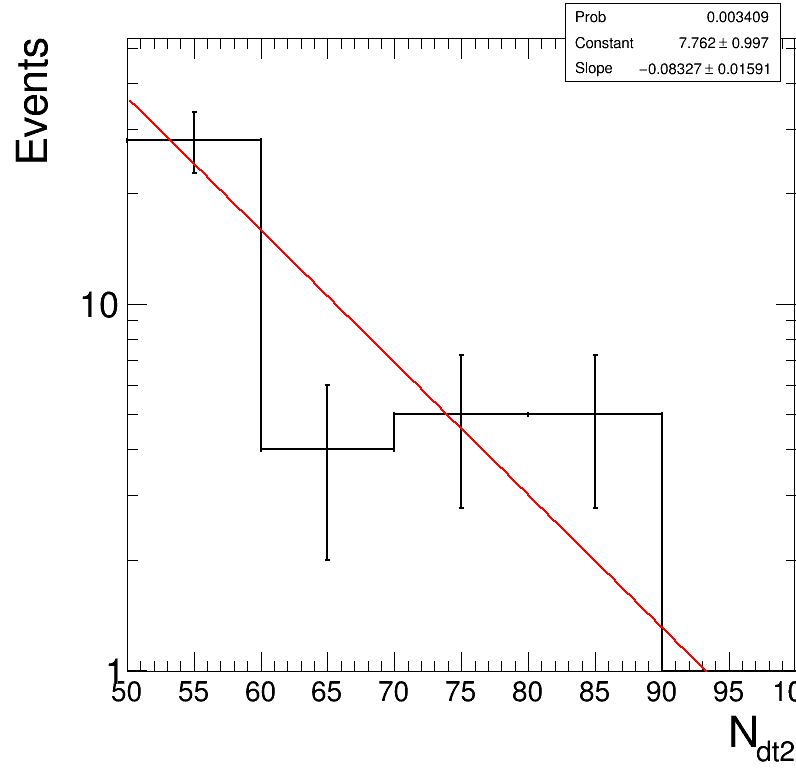

In [38]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


# Plotting ncsc
start_t = time.time()



br = 1
k = 'data'
name = '\Delta \Phi (jet,met)'
name = 'N_{dt}'
cuts = [ 50, 70, 80, 100]
# cuts = [50, 100]
if category == 0:
    var = [cscClusterSize1[k], cscClusterSize2[k]]
    varName = ['cscRechitClusterSize1', 'cscRechitClusterSize2']
    xaxis = ['N_{csc1}','N_{csc2}']
elif category == 1:
    var = [dtClusterSize1[k], dtClusterSize2[k]]
    varName = ['dtRechitClusterSize1', 'dtRechitClusterSize2']
    xaxis = ['N_{dt1}','N_{dt2}']
else:
    var = [cscClusterSize1[k], dtClusterSize1[k]]
    cuts = [ 50, 60, 70, 80, 100]

    varName = ['cscRechitClusterSize1', 'dtRechitClusterSize1']
    xaxis = ['N_{csc1}','N_{dt1}']
cut_index = 0
leg = rt.TLegend(0.6,0.77,0.90,0.92)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
r = {}
for j,v in enumerate(var):
    
        if j == 0:continue
#         cond = cscRechitClusterJetVetoPt1[k]<50
#         cond = np.logical_and(cond, cscRechitClusterJetVetoPt2[k]<50)
#         cond = np.logical_and(cond, np.abs(cscRechitClusterEta1[k])<2.2)
#         cond = np.logical_and(cond, np.abs(cscRechitClusterEta2[k])<2.2)
#         cond = np.logical_and(cond, np.abs(cscRechitClusterMuonVetoPt1[k])<30)
#         cond = np.logical_and(cond, np.abs(cscRechitClusterMuonVetoPt2[k])<30)

        h[varName[j]] = create_TH1D( np.abs(v), axis_title=[xaxis[j], 'Events'], name=k, binning=[5,50,100])
        leg.AddEntry(h[varName[j]], varName[j])
        h[varName[j]].GetXaxis().SetLabelSize(0.04)
        h[varName[j]].SetLineColor(std_color_list[0])
        r[varName[j]] = h[varName[j]].Fit('expo', 'LRSQ+', '', 50,100)
        a = r[varName[j]].Parameter(1)
        eff = math.exp(100*a)/(math.exp(50*a)-math.exp(100*a))
        a = r[varName[j]].Parameter(1) + r[varName[j]].Error(1)
        effUp = math.exp(100*a)/(math.exp(50*a)-math.exp(100*a))
        a = r[varName[j]].Parameter(1) - r[varName[j]].Error(1)
        effDown = math.exp(100*a)/(math.exp(50*a)-math.exp(100*a))
        print('Integral, efficiency, efficiencyUp, efficiencyDown, Integral*Eff^2')
        print(h[varName[j]].Integral(), eff, effUp, effDown, h[varName[j]].Integral()*eff**2 )
        h[varName[j]].GetFunction("expo").SetLineWidth(2)

        h[varName[j]].Draw('same E1')


c.SetRightMargin(0)
c.SetLogy()
# leg.Draw()
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_'+k+'_'+str(data_year)+'_'+varName[j]+'.png')
c.Draw()
# print(time.time()-start_t)

In [234]:
181*0.06*0.1


1.086

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/beamHalo/clusterPhi_metPhi.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/beamHalo/clusterPhi_metPhi.C has been generated


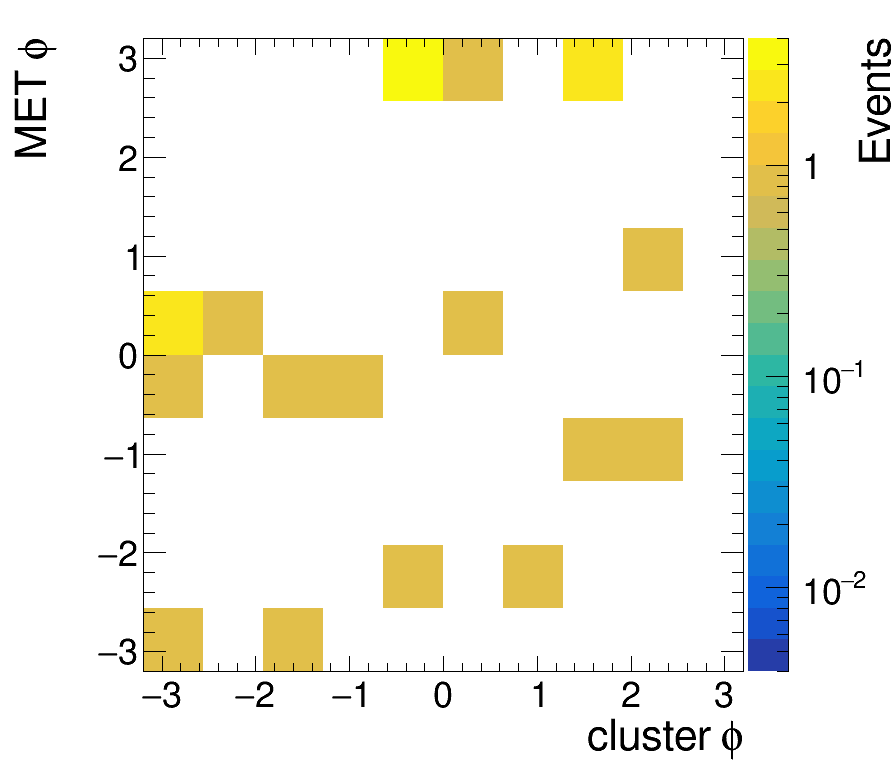

In [17]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

k = 'data_intime_beamhalo'
# k = 'data_intime_punchthrough'


c = rt.TCanvas('c','c', 900, 800)

h = {}
rt.gStyle.SetOptFit(1011)
if 'beamhalo' in k:
    h = create_TH2D( np.column_stack((cscRechitClusterPhi[k][np.logical_not(beamHaloFilter[k])].flatten(),metPhi[k][np.logical_not(beamHaloFilter[k])].flatten())), axis_title=['cluster #phi','MET #phi',\
                                                                                                                'Events'],name = 'x', binning=[10,-3.2,3.2,10,-3.2,3.2])
else:
    jetpt = 10
    h = create_TH2D( np.column_stack((cscRechitClusterPhi[k][cscRechitClusterJetVetoPt[k].flatten()>jetpt],metPhi[k][cscRechitClusterJetVetoPt[k].flatten()>jetpt])), axis_title=['cluster #phi','MET #phi',\
                                                                                                                'Events'],name = 'x', binning=[10,-3.2,3.2,10,-3.2,3.2])

h.Draw('colz')


c.SetRightMargin(0.17)
c.SetLogz()
if 'beamhalo' in k:
    c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/beamHalo/clusterPhi_metPhi.png')
    c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/beamHalo/clusterPhi_metPhi.C')
else:
    c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/clusterPhi_metPhi.png')
    c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/clusterPhi_metPhi.C')



c.Draw()



# jet punch through dphi distribution

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/dphiMet_cluster_jetpt.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/dphiMet_cluster_jetpt.C has been generated


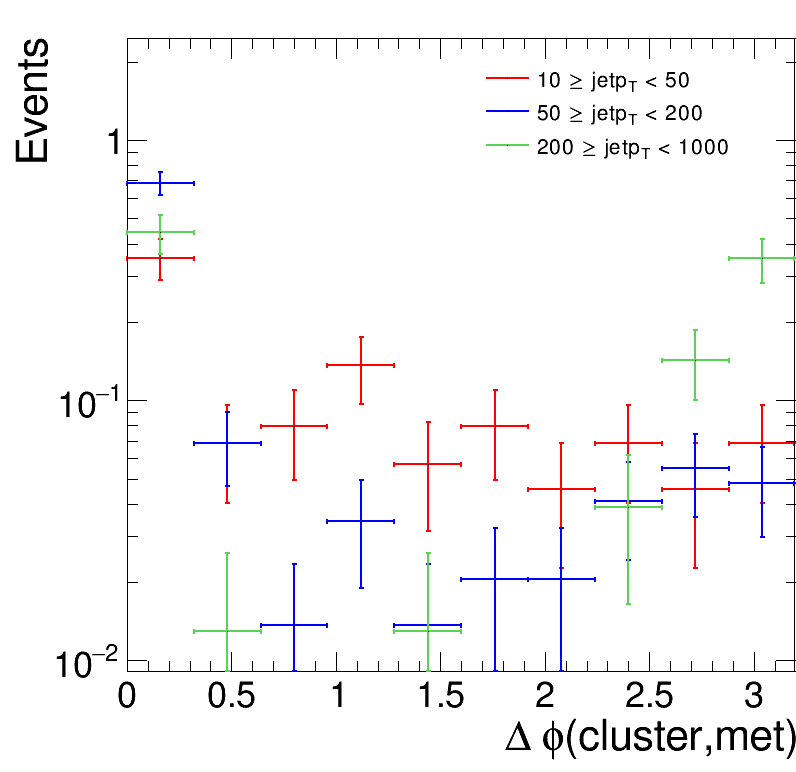

In [26]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

k = 'data_intime_punchthrough'
name = '\Delta \Phi (jet,met)'
name = 'N_{rechits}'

var = [cscRechitClusterPhi, metPhi, dphiMet_cluster, cscRechitClusterJetVetoPt, jetPt]
varName = ['cscRechitClusterPhi', 'metPhi', 'dphiMet_cluster','jetPt', 'leadingjetPt']
xaxis = ['cluster #phi', 'MET #phi', '#Delta #phi(cluster,met)', 'jet p_{T} [GeV]','leading Jet p_{T} [GeV]']
bins = [[20,-3.2,3.2], [20,-3.2,3.2], [10,0,3.2],[20,0,500], [20,0,500]]
jetpt = [10,50,200,1000]
# jetpt = []
for i, v in enumerate(var):
    if not i == 2:continue
    leg = rt.TLegend(0.6,0.79,0.90,0.92)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    rt.gStyle.SetOptFit(1011)


    h = {}
    if len(jetpt)>0:
        for j,pt in enumerate(jetpt):
            if j == 0:continue
            cond = np.logical_and(cscRechitClusterJetVetoPt[k]<pt, cscRechitClusterJetVetoPt[k]>=jetpt[j-1])
            if i == 2:
                h[j] = create_TH1D( np.abs(v[k][cond.flatten()]), axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i])
            else:
                h[j] = create_TH1D( v[k][cond.flatten()], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i])
#             print(h[j].Integral(),j)
            leg.AddEntry(h[j], str(jetpt[j-1])+'\geq \mathrm{jet p_{T}} <'+str(pt))
            h[j].SetLineColor(std_color_list[j])
#             h[j].SetMaximum(300)
#             h[j].SetMinimum(0.5)
            h[j].Scale(1/h[j].Integral())
            if j == 1:h[1].GetYaxis().SetRangeUser(0.2*min(map(lambda x: x.GetMinimum(), list(h.values()))), 7.0*max(map(lambda x: x.GetMaximum(), list(h.values()))))
            h[j].Draw('same E1')
        

    else:
        if i == 2:
            h = create_TH1D( np.abs(v[k]), axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i])
        else:
            print(v[k])
            h = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i])
        h.Draw('same E1')

    c.SetRightMargin(0)
    c.SetLogy()
    if len(jetpt)>0:leg.Draw()
    if len(jetpt)>0:
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'_jetpt.png')
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'_jetpt.C')
    else:
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'.png')
        c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'.C')        
    c.Draw()



# compare distribution in-time and OOT

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


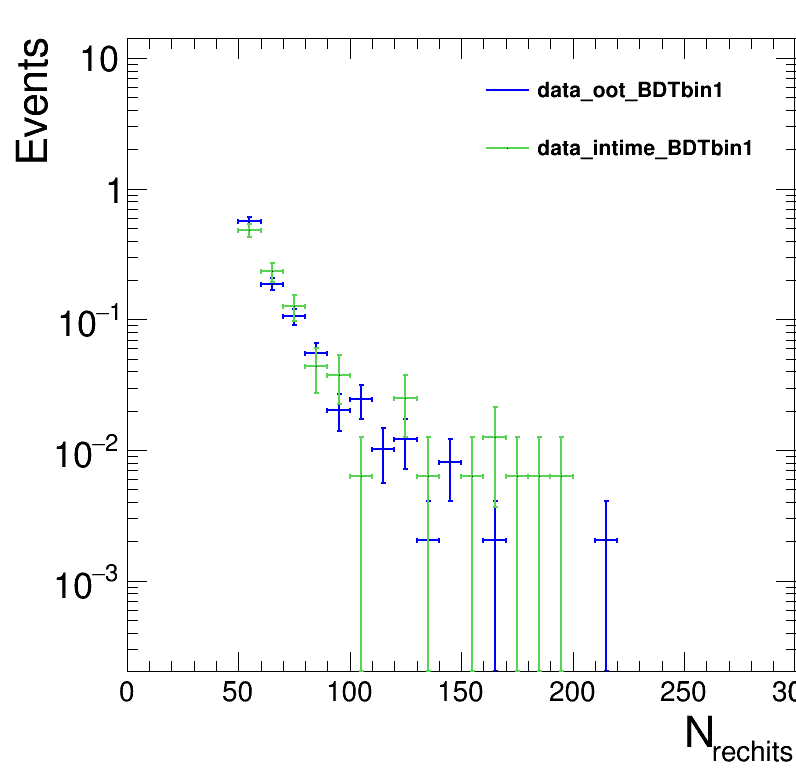

In [28]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'MC QCD background'


br = 1
name = '\Delta \Phi (jet,met)'
name = 'N_{rechits}'
cuts = [50, 90, 120, 180, 2000]
# cuts = [50, 20000]
var = [ dphiMet_cluster, nCsc_JetMuonVetoCluster0p4_Me1112Veto]
varName = ['dphiMet_cluster','nCsc_JetMuonVetoCluster0p4_Me1112Veto']
xaxis = [ '\Delta \phi(cluster,met)', 'N_{rechits}']
for j,v in enumerate(var):
    if not j ==1:continue
    leg = rt.TLegend(0.6,0.77,0.90,0.92)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    h = {}
    rt.gStyle.SetOptFit(1011)
    maxb = 0
    for i,k in enumerate(dphiMet_cluster.keys()):
        if not "1" in k:continue
        h[k] = create_TH1D( np.abs(v[k]), axis_title=[xaxis[j], 'Events'], name='h', binning=[30,0,300])

        h[k].SetMaximum(7000)
        h[k].SetMinimum(0.1)

        leg.AddEntry(h[k],k)
        h[k].GetXaxis().SetLabelSize(0.04)
        h[k].SetLineColor(std_color_list[i])
        h[k].DrawNormalized('same E1')


    c.SetRightMargin(0)
    c.SetLogy()
    leg.Draw()
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_'+k+'_'+str(data_year)+'_'+varName[j]+'.png')
    c.Draw()
# print(time.time()-start_t)

# compare time vs. time total

0.22030010513237122
0.22536557392717194


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


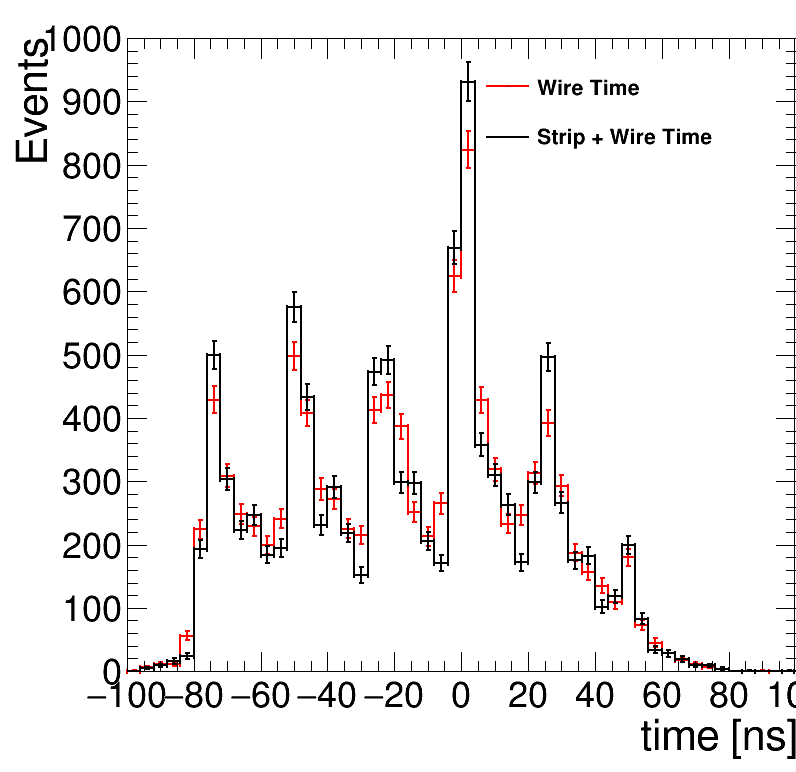

In [31]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

k = 'data_intime_BDTbin0'


leg = rt.TLegend(0.6,0.79,0.90,0.92)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)


h = {}
    
h['t'] = create_TH1D(cscClusterTime[k], axis_title=['time [ns]', 'Events'], name='h', binning=[50,-100,100])
h['total'] = create_TH1D(cscClusterTimeTotal[k], axis_title=['time [ns]', 'Events'], name='h', binning=[50,-100,100])
h['t'].SetLineColor(std_color_list[1])
h['t'].SetMaximum(1000)
leg.AddEntry(h['t'],'Wire Time')
leg.AddEntry(h['total'],'Strip + Wire Time')

print(np.count_nonzero(np.logical_and(cscClusterTime[k]<12.5,cscClusterTime[k]>-5))/len(cscClusterTime[k]))
print(np.count_nonzero(np.logical_and(cscClusterTimeTotal[k]<12.5,cscClusterTimeTotal[k]>-5))/len(cscClusterTimeTotal[k]))


# leg.AddEntry(h[j], str(jetpt[j-1])+'\geq \mathrm{jet p_{T}} <'+str(pt))
# h[j].SetLineColor(std_color_list[j])
#             h[j].SetMaximum(300)
#             h[j].SetMinimum(0.5)
# if j == 1:h[1].GetYaxis().SetRangeUser(0.2*min(map(lambda x: x.GetMinimum(), list(h.values()))), 7.0*max(map(lambda x: x.GetMaximum(), list(h.values()))))
h['t'].Draw('same hist E1')
h['total'].Draw('same hist E1')



leg.Draw()
c.SetRightMargin(0)
# c.SetLogy()
# if len(jetpt)>0:leg.Draw()
#     if len(jetpt)>0:
#         c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'_jetpt.png')
#         c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'_jetpt.C')
#     else:
#         c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'.png')
#         c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'.C')        
c.Draw()




Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


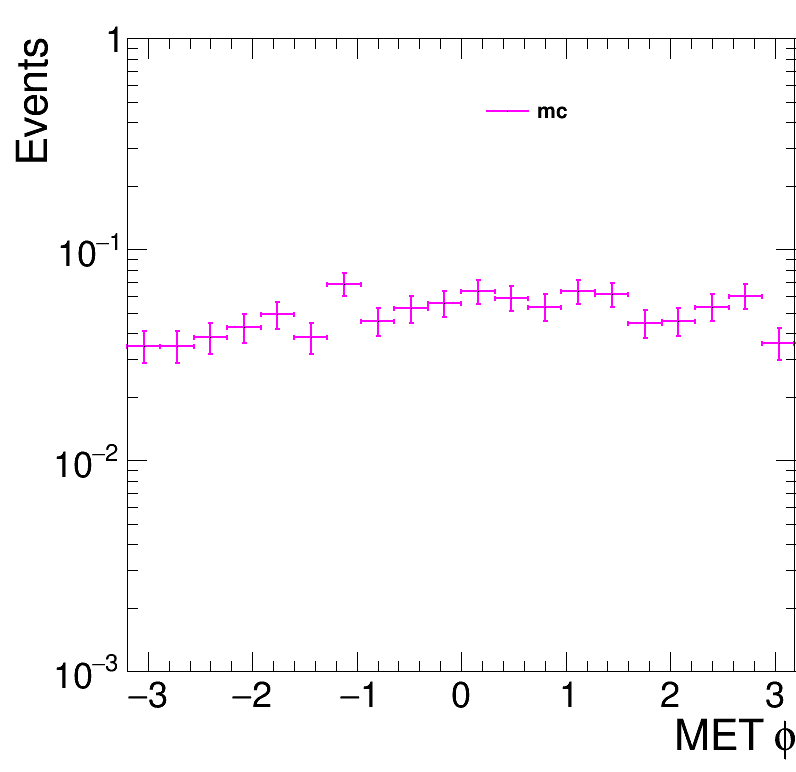

In [48]:
# met distribution

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


var = [cscRechitClusterPhi, metPhi, metPhiXYCorr, dphiMet_cluster, cscRechitClusterJetVetoPt, jetPt]
varName = ['cscRechitClusterPhi', 'metPhi', 'metPhiXYCorr', 'dphiMet_cluster','jetPt', 'leadingjetPt']
xaxis = ['cluster #phi', 'MET #phi', 'metPhiXYCorr', '#Delta #phi(cluster,met)', 'jet p_{T} [GeV]','leading Jet p_{T} [GeV]']
bins = [[20,-3.2,3.2], [20,-3.2,3.2], [20,-3.2,3.2], [20,-3,3.2],[20,0,500], [20,0,500]]
# jetpt = []
leg = rt.TLegend(0.6,0.79,0.90,0.92)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)

for i, v in enumerate(var):
    if not i == 1:continue
    h = {}

    for j, k in enumerate(metPhi.keys()):
        if 'data' in k:continue
#         cond = runNum[k]<=284044 #2016
# #         cond = np.logical_and(runNum[k]>284044, runNum[k]<=306462) #2017
# #         cond = np.logical_and(runNum[k]>306462, runNum[k]<=325273) #2018
#         cond = np.logical_and(runNum[k]>306462, runNum[k]<=319077) #2018



#         cond = runNum[k]<=325273 #all


        h[k] = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i])
        h[k].Scale(1./h[k].Integral())
        h[k].SetMaximum(1)
        h[k].SetMinimum(0.001)
        h[k].SetLineColor(std_color_list[j])
        leg.AddEntry(h[k],k)
        h[k].Draw('same E1')

    c.SetRightMargin(0)
    c.SetLogy()
    leg.Draw()
#     if len(jetpt)>0:
#         c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'_jetpt.png')
#         c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'_jetpt.C')
#     else:
#         c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'.png')
#         c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/punchThrough/'+varName[i]+'.C')        
    c.Draw()


